# Данные

In [1]:
!wget https://www.dropbox.com/s/nd7v1fod89xla6j/vk_texts_with_sources.csv

--2019-05-29 21:13:21--  https://www.dropbox.com/s/nd7v1fod89xla6j/vk_texts_with_sources.csv
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.70.1, 2620:100:6026:1::a27d:4601
Подключение к www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: /s/raw/nd7v1fod89xla6j/vk_texts_with_sources.csv [переход]
--2019-05-29 21:13:22--  https://www.dropbox.com/s/raw/nd7v1fod89xla6j/vk_texts_with_sources.csv
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uca976fd562c538cb46e54f99031.dl.dropboxusercontent.com/cd/0/inline/Ah21DsxdPCpDGcRvEmjX7WQhM6saL_c2Hbk2FS-eJktwRFaC3pO4Ugs0w8zsWnV8nzyqCKxG6zi0TGAsCKa83DseAvEmLF7cf0e1nBU_g-llhA/file# [переход]
--2019-05-29 21:13:23--  https://uca976fd562c538cb46e54f99031.dl.dropboxusercontent.com/cd/0/inline/Ah21DsxdPCpDGcRvEmjX7WQhM6saL_c2Hbk2FS-eJktwRFaC3pO4Ugs0w8zsWnV8nzyqCKxG6zi0TGAsCKa

In [2]:
import warnings
import fasttext
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('vk_texts_with_sources.csv', usecols = ['text', 'source'])
df.head()

,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


# Домашнее задание

В этом домашнем задании вы будете решать задачу тематической классификации. Даны тексты, опубликованные в нескольких пабликах VK.com, посвященных государственным и муниципальным службам. Формально задача заключается в том, чтобы по тексту ($d$) определить в каком паблике он опубликован, то есть, к какому классу $c$ он принадлежит. 

## Задание 1 [1 балл]. Описательные статистики
Посчитайте:
* количество текстов и количество классов
* количество слов (без лемматизации и с лемматизацией) в коллекции
* среднюю длину текста в словах и символах
* найдите 5 самых частых существительных в текстах каждого паблика 

*Рекомендуем использовать pandas для расчета описательных статистик.*

In [4]:
df.describe(include=[np.object])

,text,source
count,11526,11625
unique,11149,4
top,#СоветМЧС #МЧС #МЧСРОССИИ,mil
freq,45,3030


У нас 4 класса и 11625 различных текстов.

In [5]:
import nltk
import re
from pymystem3 import Mystem

nltk.download('punkt')
mystem_analyzer = Mystem()

lemmatized = []
unlemmatized = []

for doc in df['text']:
    text = re.sub("<br>", "", str(doc))
    word_list = nltk.word_tokenize(text)
    unlemmatized.append(word_list)
    lemmatized.append([mystem_analyzer.lemmatize(word)[0] for word in word_list])

[nltk_data] Downloading package punkt to /home/valeria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
print(unlemmatized[0][:10])
print("--------")
print(lemmatized[0][:10])

['Начальник', 'Главного', 'оперативного', 'управления', 'Генерального', 'штаба', 'Вооруженных', 'Сил', 'РФ', 'генерал-полковник']
--------
['начальник', 'главный', 'оперативный', 'управление', 'генеральный', 'штаб', 'вооруженный', 'сила', 'рф', 'генерал-полковник']


In [7]:
from itertools import chain

count_unlem = 0

for el in unlemmatized:
    count_unlem += len(el)

cont_lemmatized = list(chain.from_iterable(lemmatized))

print("Количество токенов в датасете:", count_unlem)
print("Количество уникальных лемм:", len(set(cont_lemmatized)))

Количество токенов в датасете: 1163263
Количество уникальных лемм: 33153


In [8]:
words_per_doc = np.mean([len(text) for text in unlemmatized])
symbols_per_doc = np.mean([len(str(doc)) for doc in df["text"]])

print("Среднее количество слов на документ:", int(words_per_doc))
print("Среднее количество символов на документ:", int(symbols_per_doc))

Среднее количество слов на документ: 100
Среднее количество символов на документ: 684


In [9]:
from collections import Counter
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm

morph = MorphAnalyzer()

tops = Counter()

for i in tqdm(range(len(df['source']))):
    for word in range(len(unlemmatized[i])):
        if morph.tag(unlemmatized[i][word])[0].POS == 'NOUN':
            tops.update([(unlemmatized[i][word], df["source"][i])])

100%|██████████| 11625/11625 [03:18<00:00, 58.63it/s]


In [10]:
nouns = {}

for key in tops:
    if key[1] not in nouns:
        nouns[key[1]] = [(key[0], tops[key])]
    else:
        nouns[key[1]].append((key[0], tops[key]))

most_common = {key : sorted([el[1] for el in nouns[key]], reverse=True)[:5] for key in nouns}

for key in most_common:
    print("Для сообщества", key, "наиболее частотны")
    for el in most_common[key]:
        for e in nouns[key]:
            if e[1] == el:
                print(e[0], el)
    print("\n")

Для сообщества mil наиболее частотны
Минобороны 1813
России 1179
обороны 799
военного 736
ходе 697


Для сообщества mchsgov наиболее частотны
МЧС 3486
России 1588
МЧСРОССИИ 1226
безопасности 342
БудниМЧС 258


Для сообщества russianpost наиболее частотны
России 2535
Почты 1130
ПочтаРоссии 936
Почта 826
года 678


Для сообщества mospolice наиболее частотны
МВД 4947
России 3890
полиции 2977
Москве 2674
полиция 2616




In [11]:
from nltk.corpus import stopwords
import pymorphy2 as pm2

pmm = pm2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")

def parse(text):
    text = re.sub(r'[^\w\s]','', str(text))
    text = re.sub("[0-9A-Za-z#_=]", "", text)
    text = [pmm.normal_forms(x)[0] for x in text.split() if x not in russian_stopwords]
    if text == [np.nan]:
        return(['nan'])
    return text

df['lemmatized'] = df['text'].apply(parse)

In [12]:
def unlem_parse(text):
    text = re.sub(r'[^\w\s]','', str(text))
    text = re.sub("[0-9A-Za-z#_=]", "", text)
    text = [x.lower() for x in text.split() if x not in russian_stopwords]
    if text == [np.nan]:
        return(['nan'])
    return text

df['unlemmatized'] = df['text'].apply(unlem_parse)

In [13]:
df.head()

,text,source,lemmatized,unlemmatized
0,Начальник Главного оперативного управления Ген...,mil,"[начальник, главный, оперативный, управление, ...","[начальник, главного, оперативного, управления..."
1,Артиллерийские подразделения общевойскового об...,mil,"[артиллерийский, подразделение, общевойсковой,...","[артиллерийские, подразделения, общевойскового..."
2,Подразделения морской пехоты Каспийской флотил...,mil,"[подразделение, морской, пехота, каспийский, ф...","[подразделения, морской, пехоты, каспийской, ф..."
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,"[команда, всеармейский, этап, конкурс, арми, т...","[команды, всеармейских, этапах, конкурсов, арм..."
4,На большом учебно-методическом командирском сб...,mil,"[на, большой, учебнометодический, командирский...","[на, большом, учебнометодическом, командирском..."


In [14]:
df['word_length'] = pd.Series([len(doc) for doc in df["lemmatized"]], index=df.index)

df.head()

,text,source,lemmatized,unlemmatized,word_length
0,Начальник Главного оперативного управления Ген...,mil,"[начальник, главный, оперативный, управление, ...","[начальник, главного, оперативного, управления...",1257
1,Артиллерийские подразделения общевойскового об...,mil,"[артиллерийский, подразделение, общевойсковой,...","[артиллерийские, подразделения, общевойскового...",67
2,Подразделения морской пехоты Каспийской флотил...,mil,"[подразделение, морской, пехота, каспийский, ф...","[подразделения, морской, пехоты, каспийской, ф...",38
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,"[команда, всеармейский, этап, конкурс, арми, т...","[команды, всеармейских, этапах, конкурсов, арм...",100
4,На большом учебно-методическом командирском сб...,mil,"[на, большой, учебнометодический, командирский...","[на, большом, учебнометодическом, командирском...",63


In [15]:
from sklearn.model_selection import train_test_split

id_source = {'mchsgov': 0,
             'mil': 1,
             'mospolice': 2,
             'russianpost': 3}

X = df.drop(columns=['source', 'lemmatized'])
y = [id_source[el] for el in df["source"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

 ## Задание 2 [2 балла]. Классификация по правилам
 
 * Разработайте несколько правил вида "Если встречается слово $w$, то текст относится к паблику $c$"
 * Посчитайте, какую точность, полноту, $f$-меру и $accuracy$ вы получаете при классификации по правилам
 * Получилось ли у вас придумать правило, которое никогда не ошибается?

Разделите коллекцию текстов на обучающую и тестовую части. 

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [33]:
texts = list(df["lemmatized"])

word_heap = []

for text in texts:
    for word in text:
        word_heap.append(word)

most_frequent_word = Counter()

for word in word_heap:
     most_frequent_word.update([(word)])

top100 = most_frequent_word.most_common(100)
most_frequent_word.most_common(5)

[('россия', 9553),
 ('год', 9163),
 ('в', 7030),
 ('полиция', 6032),
 ('мвд', 5129)]

In [34]:
def make_bow_sample(bow, sample):
    for s in sample:
        yield {word: word in s for word, _ in bow}

In [35]:
X = df.drop(columns=['source'])
y = [id_source[el] for el in df["source"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

bow_train = [(x, y) for x, y in zip(make_bow_sample(top100, X_train['lemmatized']), y_train)]
bow_validate = [x for x in make_bow_sample(top100, X_test['lemmatized'])]

In [36]:
bayes = nltk.NaiveBayesClassifier.train(bow_train)
print(bayes.show_most_informative_features())
bayes_pred = [bayes.classify(o) for o in bow_validate]

Most Informative Features
                 полиция = True                2 : 0      =   1247.4 : 1.0
                      гу = True                2 : 1      =    579.4 : 1.0
                     мвд = True                2 : 0      =    566.5 : 1.0
              минобороны = True                1 : 3      =    457.8 : 1.0
                     мчс = True                0 : 3      =    406.4 : 1.0
               задержать = True                2 : 0      =    384.2 : 1.0
             подозревать = True                2 : 0      =    319.3 : 1.0
                открытка = True                3 : 2      =    251.2 : 1.0
                  учение = True                1 : 3      =    238.5 : 1.0
                 новость = True                2 : 1      =    237.8 : 1.0
None


In [37]:
print("accuracy", accuracy_score(bayes_pred, y_test))
print("presicion", precision_score(bayes_pred, y_test, average='weighted'))
print("recall", recall_score(bayes_pred, y_test, average='weighted'))
print("F1", f1_score(bayes_pred, y_test, average='weighted'))

accuracy 0.8769872296064634
presicion 0.884540596037528
recall 0.8769872296064634
F1 0.8756620533841938


Классификация, основанная на выборе наиболее значимых для группы слов, позволяет достичь довольно высоких результатов, однако их повышение ограничена некоторыми факторами: например, в некоторых постах просто нет текста.

## Задание 3 [3 балла]. Baseline
Используйте стандартный ```sklearn.pipeline``` для классификации текстов: 
* векторизация 
* $tf-idf$ взвешивание 
* ваш любимый метод классификации.


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

X = df.drop(columns=['source', 'lemmatized'])
y = [id_source[el] for el in df["source"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

cvec = CountVectorizer()
tf_idf = TfidfTransformer()
KNN = KNeighborsClassifier()

pip = Pipeline([('vectorize', cvec), 
                ('tf-idf', tf_idf), 
                ('classify', KNN)
                    ])

In [39]:
pip.fit(X_train.text.values.astype('U'), y_train)
pip_pred = pip.predict(X_test.text.values.astype('U'))

print("accuracy", accuracy_score(pip_pred, y_test))
print("presicion", precision_score(pip_pred, y_test, average='weighted'))
print("recall", recall_score(pip_pred, y_test, average='weighted'))
print("F1", f1_score(pip_pred, y_test, average='weighted'))

accuracy 0.9494396664060464
presicion 0.9517191553961881
recall 0.9494396664060464
F1 0.9496730466979144


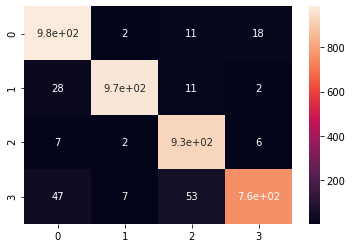

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.heatmap(data=confusion_matrix(y_test, pip_pred), annot=True)
plt.show()

## Задание 4 [2 балла]. Снижение размерности
Добавьте в ваш ```sklearn.pipeline```  методы снижения размерности:  PCA / LSI / LSA / LDA / другое. Какие методы классификации разумно использовать после снижения размерности? Как изменились результаты классификации после добавления нового шага?

In [25]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=10)
cvec = CountVectorizer()
tf_idf = TfidfTransformer()
KNN = KNeighborsClassifier()

pip = Pipeline([('vectorize', cvec), 
                ('tf-idf', tf_idf),
                ('pca', tsvd),
                ('classify', KNN)
                    ])

pip.fit(X_train.text.values.astype('U'), y_train)
pip_pred = pip.predict(X_test.text.values.astype('U'))

print("accuracy", accuracy_score(pip_pred, y_test))
print("presicion", precision_score(pip_pred, y_test, average='weighted'))
print("recall", recall_score(pip_pred, y_test, average='weighted'))
print("F1", f1_score(pip_pred, y_test, average='weighted'))

accuracy 0.9533489705499087
presicion 0.9535312871848247
recall 0.9533489705499087
F1 0.9532915616652635


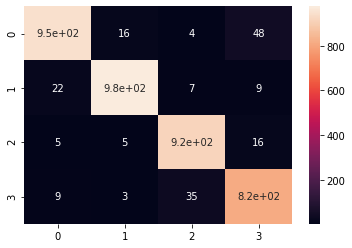

In [26]:
sns.heatmap(data=confusion_matrix(y_test, pip_pred), annot=True)
plt.show()

После снижения размерности лучше всего использовать приближенный KNN для того, чтобы избежать "curse of dimensionality". Снижение размерности позволило немного повысить качество обучения на выборке, однако чем сильнее снижение, тем хуже качество.

## Задание 5 [1 балл]. Лемматизация
Посмотрите, как влияет лемматизация на качество классификации. Как изменится качество классификации, если вы используете ```CountVectorizer``` на словах или $n$-граммах на лемматизированных текстах?

In [27]:
X = df.drop(columns=['source', 'unlemmatized'])
y = [id_source[el] for el in df["source"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [28]:
tsvd = TruncatedSVD(n_components=10)
cvec = CountVectorizer()
tf_idf = TfidfTransformer()
KNN = KNeighborsClassifier()

pip = Pipeline([('vectorize', cvec), 
                ('tf-idf', tf_idf),
                ('pca', tsvd),
                ('classify', KNN)
                    ])

pip.fit(X_train.text.values.astype('U'), y_train)
lem_pred = pip.predict(X_test.text.values.astype('U'))

print("accuracy", accuracy_score(lem_pred, y_test))
print("presicion", precision_score(lem_pred, y_test, average='weighted'))
print("recall", recall_score(lem_pred, y_test, average='weighted'))
print("F1", f1_score(lem_pred, y_test, average='weighted'))

accuracy 0.9533489705499087
presicion 0.9535440871824352
recall 0.9533489705499087
F1 0.9532957227223741


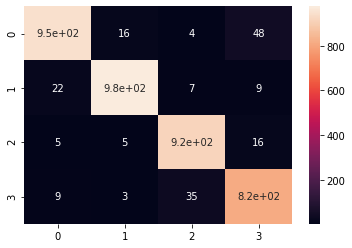

In [29]:
sns.heatmap(data=confusion_matrix(y_test, pip_pred), annot=True)
plt.show()

In [30]:
tsvd = TruncatedSVD(n_components=10)
cvec = CountVectorizer(ngram_range = (2,3))
tf_idf = TfidfTransformer()
KNN = KNeighborsClassifier()

pip = Pipeline([('vectorize', cvec), 
                ('tf-idf', tf_idf),
                ('pca', tsvd),
                ('classify', KNN)
                    ])

pip.fit(X_train.text.values.astype('U'), y_train)
lem_pred = pip.predict(X_test.text.values.astype('U'))

print("accuracy", accuracy_score(lem_pred, y_test))
print("presicion", precision_score(lem_pred, y_test, average='weighted'))
print("recall", recall_score(lem_pred, y_test, average='weighted'))
print("F1", f1_score(lem_pred, y_test, average='weighted'))

accuracy 0.7894188167839458
presicion 0.8388088377836497
recall 0.7894188167839458
F1 0.8037436613725182


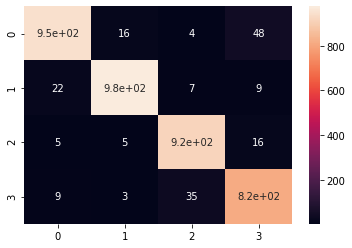

In [31]:
sns.heatmap(data=confusion_matrix(y_test, pip_pred), annot=True)
plt.show()

Лемматизация незначительно увеличила качество на отдельных словах, а при выборе н-грамм и вовсе понизила. Я считаю, это связано с потерей синтаксической соотнесенности слов в предложениях при лемматизации: теряется значительная часть грамматической информации.

## Задание 6 [3 балла]. Continious bag of words
Для baseline решения мы использовали обычное представление текста в виде мешка слов. Попробуйте использовать другие модели представления текста – например, в виде непрерывного мешка слов, то есть, в виде набора эмбеддингов. Для того, чтобы получить вектор текста попробуйте:
* усреднить все эмбеддинги слов, входящих в этот текст
* усреднить все эмбеддинги слов, входящих в этот текст с $tf-idf$ весами
* использовать любую модель эмбеддинга документа.

Используйте любую модель эмбеддингов по вашему вкусу. 


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

## Задание 7 [2 балла]. fastText

Используйте ```fastText``` в режиме классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [56]:
df["source"] = pd.Series([id_source[el] for el in df["source"]])
from sklearn.utils import shuffle
df = shuffle(df)

df.head()

,text,source,lemmatized,unlemmatized,word_length
3595,#МЧС #МЧСРОССИИ<br><br>В 2017 году было провед...,0,"[мчс, мчсроссиить, год, провести, тысяча, проф...","[мчс, мчсроссиив, году, проведено, тысяч, проф...",17
8887,В столице возбуждены уголовные дела по фактам ...,2,"[в, столица, возбудить, уголовный, дело, факт,...","[в, столице, возбуждены, уголовные, дела, факт...",18
3814,#ФактМЧС #МЧС #МЧСРОССИИ,0,"[фактмчс, мчс, мчсроссия]","[фактмчс, мчс, мчсроссии]",3
3588,#МЧС #МЧСРОССИИ <br><br>В новом выпуске #МЧС_1...,0,"[мчс, мчсроссия, в, новый, выпуск, мчсть, моск...","[мчс, мчсроссии, в, новом, выпуске, мчсв, моск...",42
9086,Сотрудники Госавтоинспекции Зеленограда провел...,2,"[сотрудник, госавтоинспекция, зеленоград, пров...","[сотрудники, госавтоинспекции, зеленограда, пр...",81


In [57]:
fd_test = open('test_corpus.txt', 'a', encoding='utf-8')
fd_train = open('train_corpus.txt', 'a', encoding='utf-8')

for idx, row in tqdm(df.iterrows()):
    if idx < 200:
        fd_test.write("__label__" + str(row["source"]) + " " + str(row["text"]) + '\n')
    else:
        fd_train.write("__label__" + str(row["source"]) + " " + str(row["text"]) + '\n')

11625it [00:01, 8432.05it/s]


In [41]:
import fastText

classifier = fastText.train_supervised('train_corpus.txt', label='__label__', epoch=10)

In [44]:
classifier.test_label('test_corpus.txt')

{'__label__1': {'precision': 0.976, 
  'recall': 0.9625246548323472,
  'f1score': 0.9692154915590864},
 '__label__0': {'precision': 0.9563492063492064,
  'recall': 0.9488188976377953,
  'f1score': 0.9525691699604744},
 '__label__2': {'precision': 0.9621451104100947,
  'recall': 0.9692796610169492,
  'f1score': 0.9656992084432717},
 '__label__3': {'precision': 0.9339407744874715,
  'recall': 0.9501738122827347,
  'f1score': 0.941987363584147}}


## Задание 8 [4 балла]. CNN

Реализуйте модель Kim et al (2014) для решения задачи классификации с помощью CNN. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix).
Ссылка: Kim Y. Convolutional Neural Networks for Sentence Classification. 2014

## Задание 9 [4 + 2 балла]. RNN

(4 балла)Используйте ```RNN``` (BLSTM с какими-то признаками и пулинг поверх) для решения задачи текстовой классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix).

За дополнительные 2 балла добавьте в модель символьные признаки - CharCNN или CharRNN

## Задание 10 [8 баллов]. ULMFit

Используйте ```ULMFit``` для решения задачи классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

## Конец
Выполните какие-то из предыдущих заданий. Для всех заданий, кроме задания 1 требуется вычислить метрику accuracy метода.

Подведите итоги и проведите сравнение всех использованных методов. Какой из них показался вам лучше и почему?

**NB!** Задание обязательное вне зависимости от того, сколько из предыдущих пунктов вы выполнили, и дополнительных баллов не дает.


Для получения полной оценки за NLP-часть достаточно набрать **20 баллов**.

# Правила сдачи 

1. Домашняя работа должна быть выполнена в ipynb-тетрадке.
2. Сделанную тетрадку нужно отправить ассистенту (ссылка на контакты будет в вики).
3. Задание выполняется индивидуально.
4. Все вычисления должны быть снабжены пояснениями!
5. Дедлайн – 10 июня в 10.00.
